# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [39]:
import pandas as pd
df = pd.read_csv('Data.csv')

## LLMChain

In [40]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [41]:
llm = ChatOpenAI(temperature=0.9)


In [42]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [43]:

chain = LLMChain(llm=llm, prompt=prompt)


In [44]:
product = "Queen Size Sheet Set"
chain.run(product)

'Royal Dreams'

## SimpleSequentialChain

In [45]:
from langchain.chains import SimpleSequentialChain

In [46]:
llm = ChatOpenAI(temperature=0.9)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [47]:

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [48]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [49]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
"Royal Comfort Bedding" or "Queen's Choice Linens"
Royal Comfort Bedding: Delivering luxurious and comfortable bedding to ensure a regal sleeping experience fit for royalty. 
Queen's Choice Linens: Providing exquisite linens handpicked for queens, offering supreme comfort and elegant style for the bedroom.

> Finished chain.


"Royal Comfort Bedding: Delivering luxurious and comfortable bedding to ensure a regal sleeping experience fit for royalty. \nQueen's Choice Linens: Providing exquisite linens handpicked for queens, offering supreme comfort and elegant style for the bedroom."

## SequentialChain

![Screenshot 2023-07-16 161656.png](<attachment:Screenshot 2023-07-16 161656.png>)
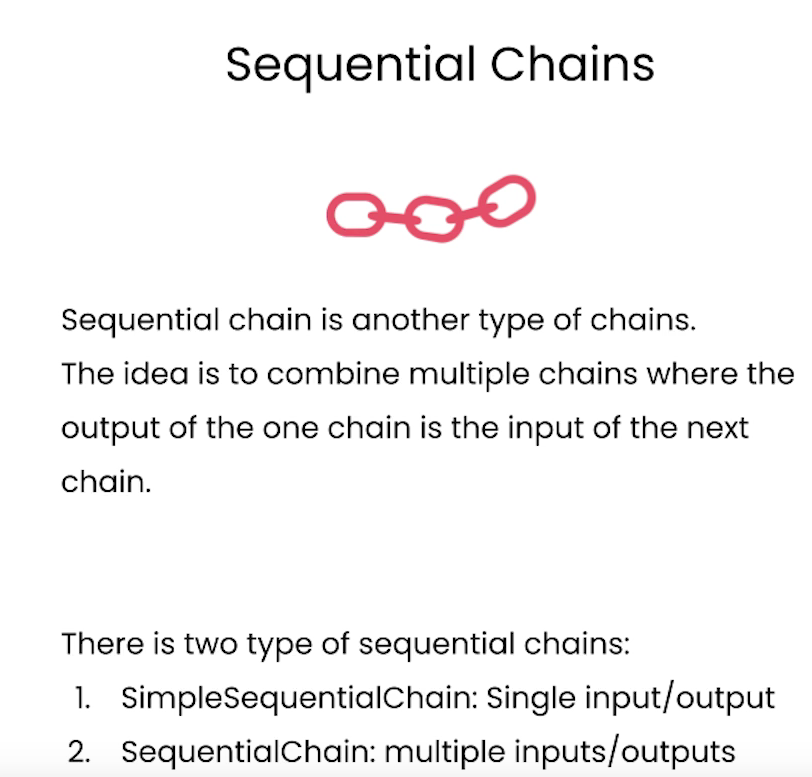

In [50]:
from langchain.chains import SequentialChain

In [51]:
llm = ChatOpenAI(temperature=0.9)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [52]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [53]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )



In [54]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [55]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [71]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste poor. The foam doesn't hold, it's weird. I buy the same ones in the store and the taste is much better...\nOld batch or counterfeit!?",
 'summary': 'The reviewer is dissatisfied with the poor taste and lack of foam in the product, suspecting that it may be an old batch or counterfeit compared to the better-tasting ones bought from the store.',
 'followup_message': "Réponse de suivi: Cher(e) client(e), \n\nNous tenons tout d'abord à vous remercier d'avoir partagé votre avis sur notre produit. Nous sommes sincèrement désolés d'apprendre que vous n'êtes pas satisfait(e) de son goût et du manque de mousse. \n\nNous tenons à vous assurer que notre produit est fabriqué avec soin et que nous prenons la qualité très au sérieux. Cependant, il est possible qu'il y ait eu un problème a

## Router Chain

![Screenshot 2023-07-16 155403.png](<attachment:Screenshot 2023-07-16 155403.png>)
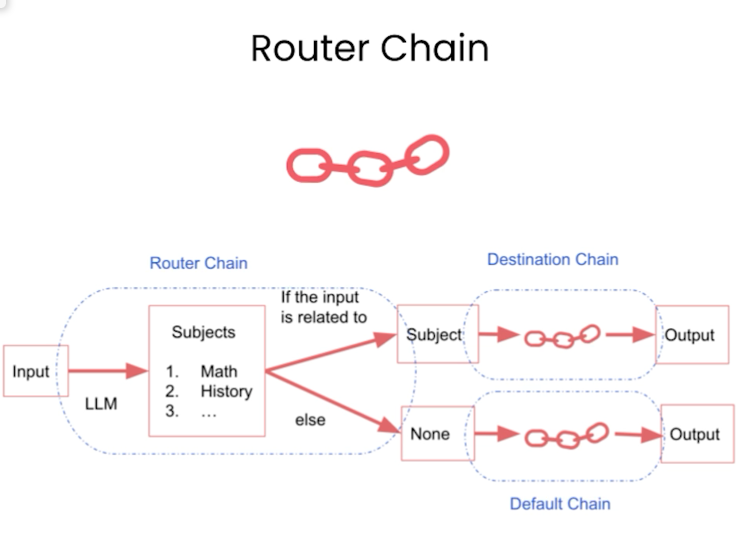

In [57]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [58]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [60]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [61]:
llm = ChatOpenAI(temperature=0)

In [64]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [63]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [65]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [66]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [67]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [68]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


'Black body radiation refers to the electromagnetic radiation emitted by an object that absorbs all incident radiation and reflects or transmits none. It is called "black body" because it absorbs all wavelengths of light, appearing black at room temperature. \n\nAccording to Planck\'s law, black body radiation is characterized by a continuous spectrum of wavelengths and intensities, which depend on the temperature of the object. As the temperature increases, the peak intensity of the radiation shifts to shorter wavelengths, resulting in a change in color from red to orange, yellow, white, and eventually blue at very high temperatures.\n\nBlack body radiation is a fundamental concept in physics and has significant applications in various fields, including astrophysics, thermodynamics, and quantum mechanics. It played a crucial role in the development of quantum theory and understanding the behavior of light and matter.'

In [69]:
chain.run("what is azimuthal quantum number")



> Entering new MultiPromptChain chain...
physics: {'input': 'what is the definition of azimuthal quantum number'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.


"The azimuthal quantum number, often denoted as l, is a quantum number that describes the shape of an electron's orbital in an atom. It determines the orbital angular momentum of the electron and the number of subshells within a given energy level. The values of l range from 0 to n-1, where n is the principal quantum number. Each value of l corresponds to a specific subshell shape: l=0 represents an s orbital, l=1 represents a p orbital, l=2 represents a d orbital, and so on."

In [70]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

None: {'input': 'Why does every cell in our body contain DNA?'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-Pu6OinGqWlMB35QvAlvwfvaN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.


'Every cell in our body contains DNA because DNA is the genetic material that carries the instructions for the development, functioning, and reproduction of all living organisms. DNA contains the information necessary for the synthesis of proteins, which are essential for the structure and function of cells. It serves as a blueprint for the production of specific proteins that determine the characteristics and traits of an organism. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next during reproduction. Therefore, every cell in our body contains DNA to ensure the proper functioning and continuity of life.'